(sec_quickstart)=

# Quickstart

This page gives some simple examples of how to use the major features
of {program}`msprime`, with links to more detailed documentation
and tutorial content.

See the {ref}`sec_installation` page for instructions on installing
{program}`msprime` (short version: ``pip install msprime`` or
``conda install -c conda-forge msprime`` will work for most users).

(sec_quickstart_ancestry)=

## Ancestry

Msprime simulates ancestral histories for a set of sample genomes
using backwards-in-time population genetic models.
Here we run a simple simulation of a short recombining sequence under
human-like parameters:

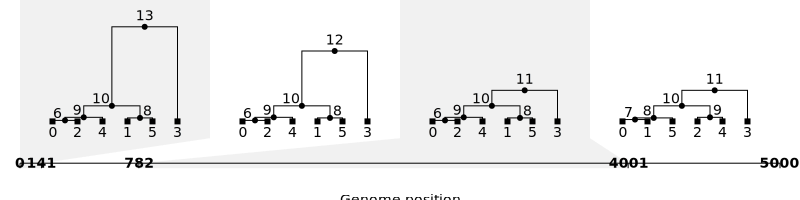

In [1]:
    import msprime
    from IPython.display import SVG, display

    # Simulate an ancestral history for 3 diploid samples under the coalescent
    # with recombination on a 5kb region with human-like parameters.
    ts = msprime.sim_ancestry(
        samples=3,
        recombination_rate=1e-8,
        sequence_length=5_000,
        population_size=10_000,
        random_seed=123456)
    # Visualise the simulated ancestral history.
    SVG(ts.draw_svg())

In this example we simulate the ancestral history of three diploid
individuals (see {ref}`sec_ancestry_samples` and {ref}`sec_ancestry_ploidy`)
for a 5kb sequence with a
[recombination](<https://en.wikipedia.org/wiki/Genetic_recombination>)
rate of {math}`10^{-8}`
(see {ref}`sec_ancestry_genome_properties`)
from a population with a constant size of 10,000 (see
the {ref}`sec_quickstart_demography` section below)
under the default
[coalescent](<https://en.wikipedia.org/wiki/Coalescent_theory>)
ancestry model (see the {ref}`sec_ancestry_models` for details on
other available models).
To ensure that
the output of this example is predictable, we set a random seed
(see {ref}`sec_randomness_seeds`).

When recombination is present, the ancestry of a sample of DNA sequences
cannot be represented by a single genealogical tree relating the
samples to their genetic ancestors; there is instead
a *sequence* of highly correlated trees along the genome.
The result of our simulation is therefore a [tree sequence](https://tskit.dev)
object from the {ref}`tskit <tskit:sec_introduction>` library,
which provides a rich suite of operations for
analysing these genealogical histories: see the
{ref}`tutorials:sec_tskit_getting_started` tutorial for help.
In this example we show a visualisation
of the four different trees along the 5kb region
(see the {ref}`tutorials:sec_tskit_viz` tutorial for more
examples).  Because we have specified three diploid sample
*individuals*, each of these trees has 6 "sample" nodes
(the "leaves" or "tips"), because each diploid individual
has two monoploid genomes (see {ref}`sec_ancestry_samples`).

See the {ref}`sec_ancestry` section for more details on
ancestry simulations.

## Mutations

The {func}`.sim_ancestry` function generates a simulated ancestral
history for some samples.
If we want [genome sequence](<https://en.wikipedia.org/wiki/Genome>)
we must also simulate some
[mutations](<https://en.wikipedia.org/wiki/Mutation>) on these trees.
However, it's important to note that it's not always necessary to
simulate mutations in order to use the simulations; often, it's
better *not to*; see the {ref}`tutorials:sec_tskit_no_mutations`
tutorial for more information.

Given an input tree sequence (which may be generated by msprime
or any other simulator that supports [tskit](https://tskit.dev)
output), we can superimpose mutations on that ancestral history
using the {func}`.sim_mutations` function under a number
of different {ref}`models<sec_mutations_models>` of sequence
evolution. For example,
here we generate some mutations for the tree sequence simulated
in the previous section under the {class}`Jukes-Cantor<.JC69>`
model:

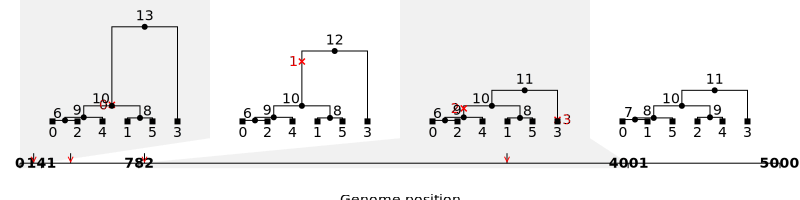

In [2]:
mutated_ts = msprime.sim_mutations(ts, rate=1e-8, random_seed=54321)
SVG(mutated_ts.draw_svg())

This visualisation shows us where the mutations occurred both in terms
of position along the genome (the tick marks with red chevrons on the
x-axis) and the branches of trees that they occurred on (the red crosses).
This information is stored in the tskit
{ref}`site<tskit:sec_site_table_definition>`
and
{ref}`mutation<tskit:sec_mutation_table_definition>` tables:

In [3]:
mutated_ts.tables.sites

id,position,ancestral_state,metadata
0,90.00000000,T,
1,333.00000000,G,
2,819.00000000,T,
3,3204.00000000,A,


In [4]:
mutated_ts.tables.mutations

id,site,node,time,derived_state,parent,metadata
0,0,10,12191.4064954057,G,-1,
1,1,10,44173.26473294006,C,-1,
2,2,9,9597.219523507081,G,-1,
3,3,3,1158.4291490099815,C,-1,


The combination of sites and mutations on a given ancestry then
defines the variants, which we can access using the
{meth}`~tskit:tskit.TreeSequence.variants` method:

In [5]:
for variant in mutated_ts.variants():
    print(variant)

{'site': {'id': 0, 'position': 90.0, 'ancestral_state': 'T', 'mutations': [{'id': 0, 'site': 0, 'node': 10, 'time': 12191.4064954057, 'derived_state': 'G', 'parent': -1, 'metadata': b''}], 'metadata': b''}, 'alleles': ('T', 'G'), 'has_missing_data': False, 'num_alleles': 2, 'genotypes': array([1, 1, 1, 0, 1, 1], dtype=int8), 'position': 90.0, 'index': 0}
{'site': {'id': 1, 'position': 333.0, 'ancestral_state': 'G', 'mutations': [{'id': 1, 'site': 1, 'node': 10, 'time': 44173.26473294006, 'derived_state': 'C', 'parent': -1, 'metadata': b''}], 'metadata': b''}, 'alleles': ('G', 'C'), 'has_missing_data': False, 'num_alleles': 2, 'genotypes': array([1, 1, 1, 0, 1, 1], dtype=int8), 'position': 333.0, 'index': 1}
{'site': {'id': 2, 'position': 819.0, 'ancestral_state': 'T', 'mutations': [{'id': 2, 'site': 2, 'node': 9, 'time': 9597.219523507081, 'derived_state': 'G', 'parent': -1, 'metadata': b''}], 'metadata': b''}, 'alleles': ('T', 'G'), 'has_missing_data': False, 'num_alleles': 2, 'genoty

:::{seealso}
See {ref}`tutorials:sec_tskit_getting_started` tutorial for more
information on how to use tree sequences to efficiently store
and analyse data.
:::

(sec_quickstart_demography)=

## Demography

By default ancestry simulations assume an extremely simple
population structure in which a single randomly mating population
of a fixed size exists for all time. For most simulations this
is an unrealistic assumption, and so msprime provides a way
to describe more complex demographic models using the
{ref}`demography API<sec_demography>`.

For example, here we define a simple three population model
in which populations "A" and "B" split from "C" 500 generations ago:

In [6]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=10_000)
demography.add_population(name="B", initial_size=5_000)
demography.add_population(name="C", initial_size=1_000)
demography.add_population_split(time=500, derived=["A", "B"], ancestral="C")
demography

Demography(populations=[Population(initial_size=10000, growth_rate=0, name='A', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=5000, growth_rate=0, name='B', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=1000, growth_rate=0, name='C', description='', extra_metadata={}, default_sampling_time=500, initially_active=False, id=2)], events=[PopulationSplit(time=500, derived=['A', 'B'], ancestral='C')], migration_matrix=array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]))

The demography API provides
{ref}`debugging tools<sec_demography_debugging_tools>` to help understand
and visualise the demographic models we define, as well as some
{ref}`numerical methods<sec_demography_numerical>` to provide analytical
predictions about these models.

We can then simulate ancestral histories conditioned on these
models using {func}`.sim_ancestry`. For example, here we simulate
5 diploid sample individuals from populations "A" and "B":

In [7]:
ts = msprime.sim_ancestry({"A": 5, "B": 5}, demography=demography, random_seed=123)
ts

See the {ref}`sec_demography` section for more details on defining
demographic models, and the {ref}`sec_ancestry_samples` section for more details
on how to specify samples under these models in ancestry simulations.